Нейросетевые модели поиска. Часть II. Переранжирование.
## Домашнее задание

В этом задании вам предстоит обучить модели переранжирования с архитектурой cross-encoder и bi-encoder на датасете [VK MARCO](https://cloud.mail.ru/public/MQ3H/GVGeAWZoj). За его решение можно получить до 10 баллов, а также еще 10 бонусных за выполнение дополнительных заданий.

**Вам надо:**

- Форкнуть эту репу;
- Создать бранч, в котором вы дальше будете работать;
- Выполнить все или часть заданий ноутбука;
- Запушить ваш бранч и поставить Pull Request.

Проверяющий счекаутит вашу бранчу и проверит работу.

**Замечания:**

- При выполнении задания можете использовать код из соответствующего семинара;
- Вам предстоит сделать как минимум 2 обучения (а при выполнении дополнительных заданий и того больше), постарайтесь переиспользовать код и минимизировать копипасты;
- Старайтесь писать чистый и понятный код, не оставляйте в ноутбуке лишний мусор (выводы ячеек с pip install, ненужный закомментированный код и т.д.);
- При сдаче дз сохраните выходы ячеек с логами обучения и графиками. Если для построения графиков вы использовали tensorboard, то вставьте графики в ноутбук в виде скриншотов;
- Итоговый ноутбук должен быть работоспособен, то есть проверяющий должен иметь возможность запустить все его ячейки в том порядке, в котором они распологаются в ноутбуке, и получить результаты, аналогичные вашим.

### Подготовка окружения

In [1]:
!pip install -r ./requirements.txt
from IPython.display import clear_output
#clear_output()

In [2]:
import csv
import sys
import numpy as np
import pandas as pd
import gc

from tqdm.notebook import tqdm

### Данные [1 балл]

Скачайте и распакуйте датасет [VK MARCO](https://cloud.mail.ru/public/MQ3H/GVGeAWZoj). Архив содержит следующие файлы (формат аналогичен MS MARCO):
* vkmarco-docs.tsv - tsv с текстами документов;
* vkmarco-doctrain-queries.tsv - tsv с текстами запросов;
* vkmarco-doctrain-qrels.tsv - tsv с оценками релевантности запроса и документа;
* Аналогичный набор файлов для валидации.

Загрузите данные трейна и валидации в pandas.DataFrame так, чтобы он содержал следующие колонки:
* qid - id запроса;
* query - текст запроса;
* text - текст документа;
* label - оценка релевантности запроса и документа.

Для экономии памяти данные немного обрабатываются

In [3]:
csv.field_size_limit(sys.maxsize)

def dataset_pandas(docs, queries_train, qrels_train, queries_vali, qrels_vali):
    text_stream = csv.reader(docs, delimiter='\t', quoting=csv.QUOTE_NONE)
    text = {}
    progress = tqdm(range(1258657), desc="reading docs")
    for _, d in zip(progress, text_stream):
        tokens = [s for s in d[3].split() if len(s) > 3]
        text[d[0]] = " ".join(tokens[::2])
        
    print("collecting results")
    result = []
    jobs = [[queries_train, qrels_train], [queries_vali, qrels_vali]]
    for queries, qrels in jobs:
        rows = []
        query_stream = csv.reader(queries, delimiter='\t')
        query = {}
        for q in query_stream:
            query[q[0]] = q[1]
        
        field_stream = csv.reader(qrels, delimiter=' ')
        rows = []
        for field in field_stream:
            row = [int(field[0]), query[field[0]], text[field[2]], int(field[3])]
            rows.append(row)
            
        result.append(pd.DataFrame(rows, columns=['qid', 'query', 'text', 'label']))

    return result

In [4]:
data, test = dataset_pandas(
    open("./data/vkmarcoranking-v1-document/vkmarco-docs.tsv"), 
    open("./data/vkmarcoranking-v1-document/vkmarco-doctrain-queries.tsv"), 
    open("./data/vkmarcoranking-v1-document/vkmarco-doctrain-qrels.tsv"),
    open("./data/vkmarcoranking-v1-document/vkmarco-docdev-queries.tsv"), 
    open("./data/vkmarcoranking-v1-document/vkmarco-docdev-qrels.tsv")
)
gc.collect()

reading docs:   0%|          | 0/1258657 [00:00<?, ?it/s]

collecting results


17

In [6]:
VALID_SIZE = 300
valid = data[(42700 - VALID_SIZE < data['qid']) & (data['qid'] <= 42700)]
train = data[data['qid'] <= 72700 - VALID_SIZE]

In [7]:
valid

,qid,query,text,label
992201,42401,скачать песни ночная бабочка,Скачать Ночная Мэвл бесплатно онлайн версию Ан...,1
992202,42401,скачать песни ночная бабочка,данной можете бесплатно KA-DO бабочка онлайн Т...,2
992203,42401,скачать песни ночная бабочка,Слушать Мэвл бабочка телефон музыка качестве k...,3
992204,42401,скачать песни ночная бабочка,Скачивайте Мэвл Бабочка онлайн Мэвл Бабочка Но...,1
992205,42401,скачать песни ночная бабочка,"Мэвл Бабочка качестве мобильные андроид, айфон...",3
...,...,...,...,...
1000777,42699,человек нарушает российские законы как это мож...,null гражданство гражданину получить канады ро...,1
1000778,42699,человек нарушает российские законы как это мож...,null 1812 История Книги XVIII-XIX Писатели ист...,1
1000779,42699,человек нарушает российские законы как это мож...,Подробно оформлении визы жителей других СНГ: д...,2
1000780,42700,чем 1 января венги трут руки вместа мыла,"Вопросы викторины. ответ января года умываясь,...",3


In [8]:
train

,qid,query,text,label
0,1,0 00 дом muzono net raim feat artur adil скачать,Скачивай raim Zvuk.top! месяца Блондинка Газма...,1
1,1,0 00 дом muzono net raim feat artur adil скачать,Скачать RaiM Artur бесплатно RaiM Artur 2018 R...,3
2,1,0 00 дом muzono net raim feat artur adil скачать,"Скачать RaiM Adil mp3, 7,46 kbps, 3:12 бесплат...",2
3,1,0 00 дом muzono net raim feat artur adil скачать,Скачать feat. Adil Качество: Длительность: так...,2
4,1,0 00 дом muzono net raim feat artur adil скачать,Здесь бесплатно RaiM Artur Mussic.kz. казахски...,2
...,...,...,...,...
1002625,42770,հեպ 9 դասագիրք,null Մայիս տարվա նահանջ 130-րդ) ավարտին Դեպքեր...,1
1002626,42770,հեպ 9 դասագիրք,null English 2022 Ереванский университет Автор...,0
1002627,42771,美女的胸,系统漫画《大英雄的女友超级凶》，简介：根据阿里巴巴文学二次元签约作者大仙的同名小说改编。他是...,0
1002628,42771,美女的胸,"Смотрите 善良的女祕書 Видео 2017 качестве, бесплатно...",0


In [9]:
test

,qid,query,text,label
0,5,05 05 2019 выходной,"Выходные, рабочие году! января Главная MYGO пу...",2
1,5,05 05 2019 выходной,Официальные выходные года дней. выходных Произ...,2
2,5,05 05 2019 выходной,null 2019 России выходных указано Кодексе Евге...,2
3,5,05 05 2019 выходной,"рабочем 2022 выходные, продолжительность предп...",1
4,5,05 05 2019 выходной,2019 украинцев дополнительные числа труда побе...,1
...,...,...,...,...
153367,42757,югра безопасность урай реквизиты,"""Информация """"ЮГРА-БЕЗОПАСНОСТЬ"""" Найти """"ЮГРА...",3
153368,42757,югра безопасность урай реквизиты,"""ООО Урай 1048600100438 860601001 Контакты Фин...",3
153369,42757,югра безопасность урай реквизиты,"""ООО Урай: руководство, учредители данные ОГРН...",2
153370,42757,югра безопасность урай реквизиты,"""ИНН, юридический директора """"ЮГРА-БЕЗОПАСНОСТ...",2


### Baselines \[2 балла\]

Реализуйте подсчет метрик MRR@k и NDCG@k. Посчитайте их значения на валидационном сете для нескольких бейзлайнов:
1. Модель, делающая случайное предсказание;
1. BM25.

Подсчет метрик

In [10]:
import torch

from torchmetrics.retrieval import RetrievalMRR, RetrievalNormalizedDCG

print(torch.cuda.is_available())

def MRR(preds, target, qids, k=10):
    mrr = RetrievalMRR(top_k=k)
    
    return mrr(torch.Tensor(preds), 
               torch.Tensor(target), 
               indexes=torch.LongTensor(qids - min(qids)))

def NDCG(preds, target, qids, k=10):
    ndcg = RetrievalNormalizedDCG(top_k=k)
    
    return ndcg(torch.Tensor(preds),
                torch.Tensor(target),
                indexes=torch.LongTensor(qids - min(qids)))

False


Случайные предсказания

In [11]:
prediction = np.random.random(len(test))
print("MRR, релевантные - 2 и 3:", MRR(prediction, (test['label'] > 1), test['qid'].values))
print("MRR, релевантные - 3:", MRR(prediction, (test['label'] > 2), test['qid'].values))
print("NDCG:", NDCG(prediction, test['label'].values, test['qid'].values))

MRR, релевантные - 2 и 3: tensor(0.5811)
MRR, релевантные - 3: tensor(0.2267)
NDCG: tensor(0.6873)


BM25

In [12]:
"""from rank_bm25 import BM25Okapi

corpus = test['text'].values
tokenized_corpus = [doc.split(" ") for doc in tqdm(corpus)]
bm25 = BM25Okapi(tokenized_corpus)"""

'from rank_bm25 import BM25Okapi\n\ncorpus = test[\'text\'].values\ntokenized_corpus = [doc.split(" ") for doc in tqdm(corpus)]\nbm25 = BM25Okapi(tokenized_corpus)'

In [13]:
"""def get_bm25_scores():
    queries = test['query'].unique()
    bm25_preds = np.zeros(len(test))
    for q in tqdm(queries):
        tokenized_query = q.split(" ")
        doc_scores = bm25.get_scores(tokenized_query)
        mask = test['query'] == q
        bm25_preds[mask] = doc_scores[mask]
    return bm25_preds"""

'def get_bm25_scores():\n    queries = test[\'query\'].unique()\n    bm25_preds = np.zeros(len(test))\n    for q in tqdm(queries):\n        tokenized_query = q.split(" ")\n        doc_scores = bm25.get_scores(tokenized_query)\n        mask = test[\'query\'] == q\n        bm25_preds[mask] = doc_scores[mask]\n    return bm25_preds'

In [14]:
"""bm25_preds = get_bm25_scores()"""

'bm25_preds = get_bm25_scores()'

In [15]:
"""prediction = bm25_preds
print("MRR, релевантные - 2 и 3:", MRR(prediction, (test['label'] > 1), test['qid'].values))
print("MRR, релевантные - 3:", MRR(prediction, (test['label'] > 2), test['qid'].values))
print("NDCG:", NDCG(prediction, test['label'].values, test['qid'].values))"""

'prediction = bm25_preds\nprint("MRR, релевантные - 2 и 3:", MRR(prediction, (test[\'label\'] > 1), test[\'qid\'].values))\nprint("MRR, релевантные - 3:", MRR(prediction, (test[\'label\'] > 2), test[\'qid\'].values))\nprint("NDCG:", NDCG(prediction, test[\'label\'].values, test[\'qid\'].values))'

### Обучение cross-encoder \[2 балла\]

Выполните следующие задания:
* Обучите модель xlm-roberta-base в фомате cross-encoder.
* Постройте графики зависимости метрик от количества пройденных шагов.
* Посчитайте метрики для финальной модели.
* Сколько времени заняло обучение?

Импорты

In [16]:
import transformers
from torch import nn
from torch.utils import data
from torch.utils.data import Dataset
import numpy as np
from transformers import AutoTokenizer, AutoModel, XLMRobertaTokenizer, XLMRobertaTokenizer
from sklearn.metrics import roc_auc_score
# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter

Класс для модели

In [17]:
class RankBert(nn.Module):
    def __init__(self, train_layers_count=2):
        super(RankBert, self).__init__()

        self.bert = AutoModel.from_pretrained("xlm-roberta-base")
        self.config = self.bert.config

        # freeze all layers without bias and LN
        for name, par in self.bert.named_parameters():
            if 'bias' in name or 'LayerNorm' in name:
                continue
            par.requires_grad = False

        layer_count = self.config.num_hidden_layers
        for i in range(train_layers_count): #unfreeze somw layers
            for par in self.bert.encoder.layer[layer_count - 1 - i].parameters():
                par.requires_grad = True
        
        # map cls token emb to relevance score
        self.head = nn.Linear(self.config.hidden_size, 1) 
        
    def forward(self, input_ids, token_type_ids=None, attention_mask=None):
        x = self.bert(input_ids=input_ids,
                      token_type_ids=token_type_ids,
                      attention_mask=attention_mask
                      )[0][:, 0, :] #hidden_state of [CLS]
        x = self.head(x)
        return x


### Подготовка данных

In [18]:
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')

class RankDataset(Dataset):
    def __init__(self, data, neg_p=1.0):
        self.neg_p = neg_p
        if self.neg_p < 1.:
            self.data = pd.concat([data[data['label'] == 3], 
                                   data[data['label'] < 3].sample(frac=self.neg_p)])
        else:
            self.data = data
        
    def __getitem__(self, index):
        query, text, label = self.data.iloc[index, [1, 2, 3]]

        return [query.lower(), text.lower()], label

    def __len__(self):
        return len(self.data)
    
def compose_batch(batch):
    texts = [x for x, _ in batch]
    ys = torch.tensor([y for _, y in batch]).reshape((-1, 1)).float()

    tokens = tokenizer(texts, padding=True, truncation=True, max_length=64, return_tensors='pt')

    return tokens, ys

Создание датасетов для обучения

In [19]:
dataset_train = RankDataset(train, neg_p=0.3)
dataset_valid = RankDataset(valid, neg_p=1.)

train_dataloader = data.DataLoader(dataset_train, shuffle=True, batch_size=128, collate_fn=compose_batch, num_workers=2)
valid_dataloader = data.DataLoader(dataset_valid, shuffle=False, batch_size=128, collate_fn=compose_batch)

### Обучение модели

Создание модели

In [20]:
model = RankBert(train_layers_count=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

RankBert(
  (bert): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (Lay

Шаги модели

In [21]:
!mkdir cross_encоder_checkpoint

mkdir: cannot create directory ‘cross_encоder_checkpoint’: File exists


In [22]:
class config:
    EPOCHS=1
    LR=1e-4
    WD=0.01
    SAVE_DIR="cross_encоder_checkpoint"
    SAVE_INTERVAL=1000
    BATCH_SIZE=64
    ACCUM_BS=1
    DEVICE=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    LOG_INTERVAL=250

writer = SummaryWriter('cross_encоder_checkpoint/ms_marco_v2')

loss_fn = nn.BCEWithLogitsLoss()

In [23]:
#!rm -rf cross_encоder_checkpoint

In [24]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config.LR, weight_decay=config.WD)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                pct_start=0.1,
                                                max_lr=config.LR,
                                                epochs=config.EPOCHS, 
                                                steps_per_epoch=len(train_dataloader))

Перенос данных

In [25]:
def move_batch_to_device(batch, device):
    batch_x, y = batch
    for key in batch_x:
        batch_x[key] = batch_x[key].to(device)
    y = y.to(device)
    return batch_x, y

Обучение одной эпохи

In [26]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    running_auc = 0.
    last_loss = 0.

    device = config.DEVICE
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, batch in enumerate(train_dataloader):
        # Every data instance is an input + label pair
        batch_x, y = move_batch_to_device(batch, device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(**batch_x)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, y)
        loss.backward()

        # Adjust learning weights
        optimizer.step()
        scheduler.step()

        # Gather data and report
        running_loss += loss.item()

        y = y.cpu().int().numpy()
        if y.sum() > 0:
            #compute metric
            with torch.no_grad():
                auc = roc_auc_score(y, 
                                    outputs.cpu().numpy(), 
                                    labels=np.array([0, 1, 2, 3]),
                                    multi_class='ovo',
                                    average='weighted')
            running_auc += np.mean(auc)
        else:
            running_auc += 1
        
        #logging to tb
        tb_x = epoch_index * len(train_dataloader) + i + 1
        tb_writer.add_scalar('lr', scheduler.get_last_lr()[0], tb_x)
        tb_writer.add_scalar('Train/auc', auc, tb_x)
        tb_writer.add_scalar('Train/loss', loss, tb_x)
        
        if i % config.LOG_INTERVAL == config.LOG_INTERVAL - 1:
            last_loss = running_loss / config.LOG_INTERVAL # loss per batch
            last_auc = running_auc / config.LOG_INTERVAL # loss per batch
            print('  batch {} loss: {}, auc: {}'.format(i + 1, last_loss, last_auc))
            
            tb_writer.add_scalar('Train/running_loss', last_loss, tb_x)
            tb_writer.add_scalar('Train/running_auc', last_auc, tb_x)
            running_loss = 0.
            running_auc = 0.

        if i % 10 == 0: #clean up memory
            gc.collect()
            torch.cuda.empty_cache()

    return last_loss, last_auc

Обучение Модели

In [27]:
epoch_number = 0

best_vloss = 1_000_000.

for epoch in range(config.EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss, avg_auc = train_one_epoch(epoch_number, writer)
    
    running_vloss = 0.0
    running_vauc = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        preds = []
        for i, batch in enumerate(valid_dataloader):
            batch_x, y = move_batch_to_device(batch, config.DEVICE)
            voutputs = model(**batch_x)
            vloss = loss_fn(voutputs, y)
            running_vloss += vloss

            y = y.cpu().int().numpy()
            if y.sum() > 0:
                #compute metric
                with torch.no_grad():
                    auc = roc_auc_score(y, 
                                        voutputs.cpu().numpy(), 
                                        labels=np.array([0, 1, 2, 3]),
                                        multi_class='ovo',
                                        average='weighted')
                running_vauc += np.mean(auc)
            else:
                running_vauc += 1
                
            preds.append(voutputs)

    #compute valid mrr
    preds = torch.cat(preds).view(-1).cpu()
    val_mrr = MRR(preds, (val_data['label'].values < 3), val_data['qid'].values)
    val_ndcg = NDCG(preds, val_data['label'].values, val_data['qid'].values)

    avg_vloss = running_vloss / (i + 1)
    avg_vauc = running_vauc / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
    print('AUC train {} valid {}'.format(avg_auc, avg_vauc))
    print('MRR valid {}'.format(val_mrr))
    print('NDCG valid {}'.format(val_ndcg))

    writer.add_scalar('Valid/mrr', val_mrr, epoch)
    writer.add_scalar('Valid/ndcg', val_ndcg, epoch)
    writer.add_scalar('Valid/loss', avg_vloss, epoch)
    writer.add_scalar('Valid/auc', avg_vauc, epoch)
    
    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss

        checkpoint = {'epoch': epoch, 'model_state_dict': model.state_dict(),
                      'optimizer_state_dict': optimizer.state_dict(),
                      'scheduler_state_dict': scheduler.state_dict(),
                      'best_vloss': best_vloss}

        torch.save(checkpoint, f'{config.SAVE_DIR}/ckpt_epoch_{epoch}_loss{best_vloss}.pt')

    epoch_number += 1

EPOCH 1:


ValueError: Target scores need to be probabilities for multiclass roc_auc, i.e. they should sum up to 1.0 over classes

### Обучение bi-encoder \[4 балла\]

Вспомним, что разница между cross-encoder и bi-encoder моделями заключается способе получения скора релевантности:

| Cross-encoder | Bi-encoder |
| - | - |
| 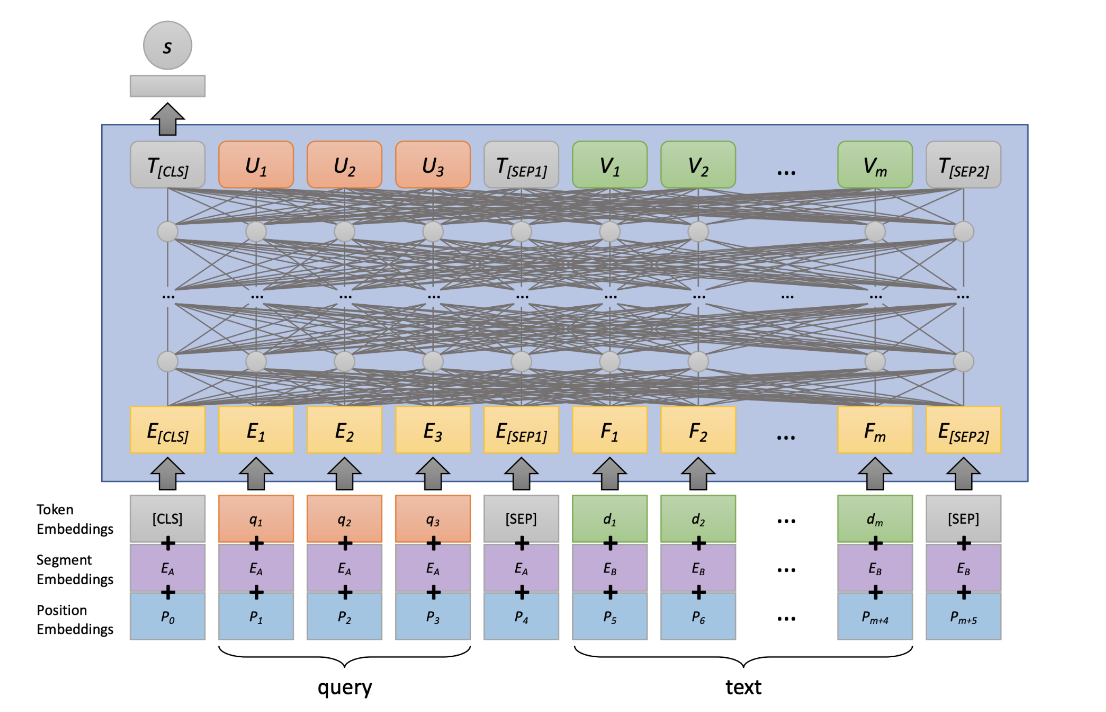 | 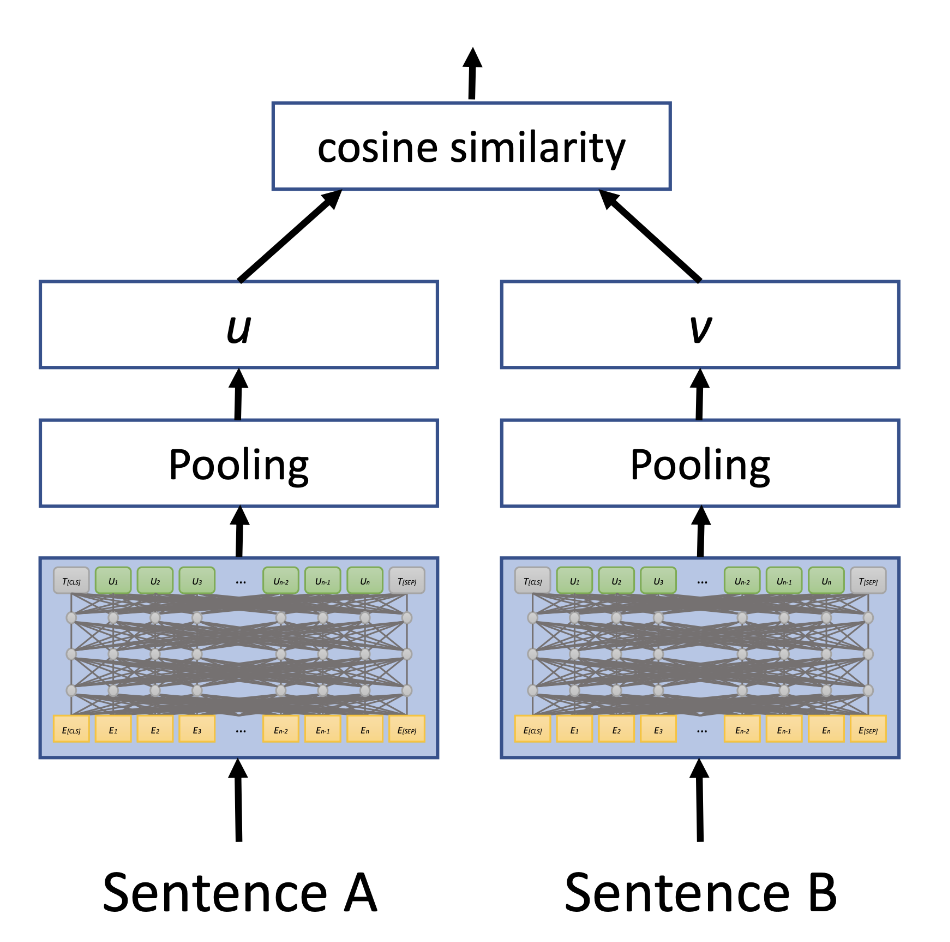 |

Выполните следующие задания:
* Внесите необходимые изменения в код и обучите xlm-roberta-base в фомате bi-encoder.
* Постройте графики зависимости метрик от количества пройденных шагов.
* Посчитайте метрики для финальной модели.
* Сколько времени заняло обучение?

In [ ]:
# YOUR CODE HERE

### Сравнение cross-encoder и bi-encoder архитектур \[2 балла\]

Выполните следующие задания:
* Сравните графики обучения моделей, скорость обучения и скорость инфернса.
* Напишите вывод.

### Дополнительно \[10 баллов\]

Вы можете получить дополнительные баллы, выполнив одно или несколько заданий:
* Обучите cross-encoder в fp16 с использованием AMP, посчитайте метрики, есть ли изменения? **[1 балла]**
* Реализуйте семплирование примеров с учетом их длинны, насколько ускорилось обучение cross-encoder? **[1 балла]**
* Попробуйте увеличить метрики bi-encoder за счет использования другого претрейна. Кроме xlm-roberta-base на [Huggingface](https://huggingface.co/models) есть большое количество предобученных моделей BERT. Датасет содержит тексты на русском языке, поэтому стоит обратить внимание на русскоязычные или мультиязычные претрейны. Если вам удасться улучшить метрику, то предположите, какие отличия претрейна на это повлияли. **[2 балла]**
* Попробуйте разморозить больше параметров модели (например, последний трансформерный слой). Как изменилось качество и скорость обучения? **[2 балла]**
* Попробуйте использовать listwise лосс для обучения модели, как изменились метрики? **[4 балла]**

In [ ]:
# YOUR CODE HERE